In [1]:
%load_ext autoreload
%autoreload 2
import torch
from logistic import LogisticRegression, GradientDescentOptimizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Abstract

Abstract

### Experiments

#### Generating Experimental Data

In [2]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

#### Experiments

##### Vanilla Gradient Descent

We'll start with our most simple experiment. We want to look at a case with a small value for $\alpha$ and with $\beta = 0$ and show that this method of descending down the gradient to minimize the loss function will converge to a ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍weight ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍vector ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍**w** that looks visually correct. That is, when we plot the decision boundary we should see that this algorithm is able to split the data fairly well. We also want to show that as we do more iterations, the loss should be decreasing monotonically, which means that it is only decreasing and never increases as we do more iterations. We'll plot both the decision boundary and the loss function after implementing the gradient descent method to check that these criteria have been met. First, we will generate some data using the above function and train it using a gradient descent loop. 

In [18]:
import matplotlib.pyplot as plt

# generate classification data
X, y = classification_data(n_points = 500, noise=0.5, p_dims=2)

# create model and optimizer
model = LogisticRegression()
optimizer = GradientDescentOptimizer(model)

# track loss over time
losses_vanilla = []

# run vanilla gradient descent loop (train the model)
for _ in range(100):
    loss_vanilla = model.loss(X, y).item()
    losses_vanilla.append(loss_vanilla)
    optimizer.step(X, y, alpha=0.1, beta=0.0)

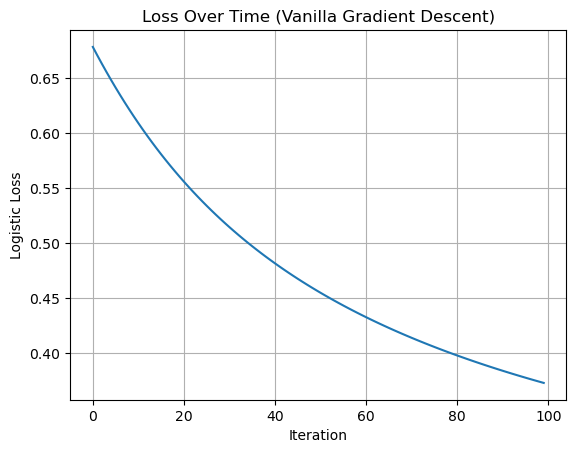

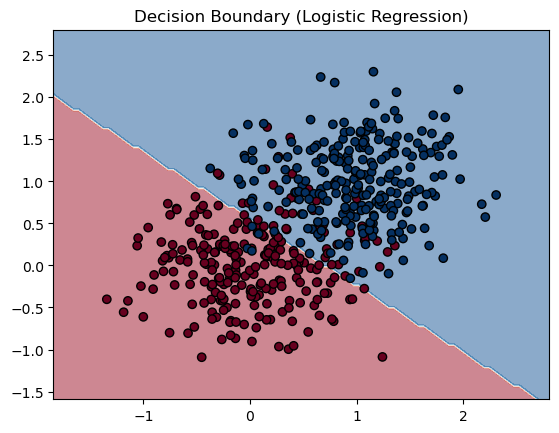

In [19]:
#| code-fold:true
# plot the loss over iterations
plt.plot(losses_vanilla)
plt.xlabel("Iteration")
plt.ylabel("Logistic Loss")
plt.title("Loss Over Time (Vanilla Gradient Descent)")
plt.grid(True)
plt.show()

# plot decision boundary with data
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = torch.meshgrid(torch.linspace(x_min, x_max, 100),
                            torch.linspace(y_min, y_max, 100),
                            indexing='xy')
    
    # add bias column of ones
    grid = torch.cat((xx.reshape(-1,1), yy.reshape(-1,1), torch.ones((xx.numel(), 1))), dim=1)
    preds = model.predict(grid).reshape(xx.shape)

    plt.contourf(xx, yy, preds, alpha=0.5, cmap="RdBu")
    plt.scatter(X[:,0], X[:,1], c=y, cmap="RdBu", edgecolor='k')
    plt.title("Decision Boundary (Logistic Regression)")
    plt.show()

plot_decision_boundary(model, X, y)

Looking at these plots, we can see that both of the criteria we described above are met by the vanilla gradient descent model. The loss function is only decreasing as we do more iterations of the gradient descent process, and we can see that the decision boundary generated by the model was able to split the data fairly well, although not perfectly. This makes sense because our dataset has noise and we can see from the plot that it would be impossible to separate this data using a linear decision boundary. 

##### Benefits ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍of ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍momentum

Now, we'll take a look at what this process looks like on the same data with a different $\beta$ (momentum) value. Gradient descent with momentum can converge to the correct weights in fewer iterations than it does without momentum ($\beta = 0$, as seen above with vanilla gradient descent). 

In [17]:
# run momentum gradient descent loop (train the model)
losses_momentum = []
for _ in range(100):
    loss_momentum = model.loss(X, y).item()
    losses_momentum.append(loss_momentum)
    optimizer.step(X, y, alpha=0.1, beta=0.9)

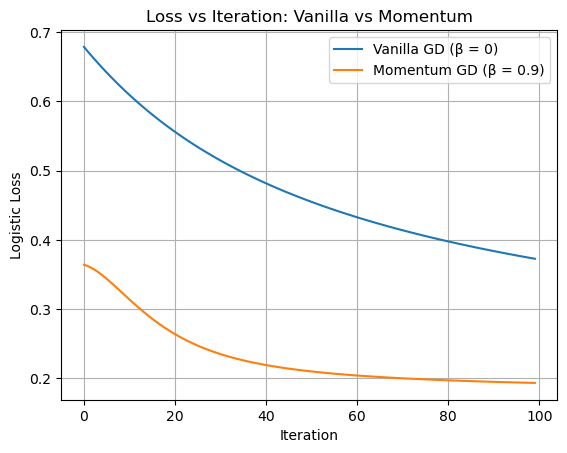

In [21]:
# plot the loss over iterations for momentum
plt.plot(losses_vanilla, label="Vanilla GD (β = 0)")
plt.plot(losses_momentum, label="Momentum GD (β = 0.9)")
plt.xlabel("Iteration")
plt.ylabel("Logistic Loss")
plt.title("Loss vs Iteration: Vanilla vs Momentum")
plt.legend()
plt.grid(True)
plt.show()

In the plot we can see that when we add momentum to the gradient descent method (orange line), the loss is minimized more quickly than the vanilla gradient descent process (blue line). Thus, momentum can be a beneficial addition to the gradient descent process. 

##### Overfitting

Now, we'll take a look at an example of overfitting. We will generate two datasets, both with more dimensions (features) than the number points. Then, we'll train a model on the train set that achieves 100% accurate for this train set and we will see how this model performs on the test set. 

In [31]:
# generate data
X_train, y_train = classification_data(n_points = 50, noise=0.5, p_dims=100)
X_test, y_test = classification_data(n_points = 50, noise=0.5, p_dims=100)

In [32]:
# initialize model
model = LogisticRegression()
opt = GradientDescentOptimizer(model)

# train model
for _ in range(300):
    opt.step(X_train, y_train, alpha=0.1, beta=0.5)

# evaluate model on train set
train_preds = model.predict(X_train)
train_acc = (train_preds == y_train).float().mean().item()

In [33]:
#| echo:false
print(f"Train Accuracy: {train_acc:.2%}")

Train Accuracy: 100.00%


Now that we have a model that performs with 100% accuracy on the train set, let's test it using the test set. 

In [34]:
# evaluate model on train set
test_preds = model.predict(X_test)
test_acc = (test_preds == y_test).float().mean().item()

In [35]:
#| echo:false
print(f"Test Accuracy: {test_acc:.2%}")

Test Accuracy: 86.00%


As we can see from the lower testing accuracy than training accuracy, this is an example of overfitting. We created an overparameterized classification problem by making more features than points in the dataset. So, although the model was able to fit the training data perfectly, it was fitting a model that was too complex to generalize well. This is why we saw a much lower accuracy on the train set -- the model learned patterns in the train data that didn't actually apply to the data more generally.  

##### Performance ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍on ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍empirical ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data

Now, we'll test out this model on a real dataset. We'll use a dataset called the Pima Indians Diabetes Dataset that originates from the National Institute of Diabetes and Digestive and Kidney Diseases and is available through the UCI Machine Learning Repository. ​The dataset comprises medical records for 768 female patients of Pima Indian heritage, aged 21 and above. Each record includes 8 numerical attributes related to medical measurements and personal information, along with a binary outcome indicating the presence or absence of diabetes. First, we'll load and process the data so that we can use it with our custom logistic regression model. We need to normalize the features and add a bias column before train-test splitting. 

In [36]:
# load and preprocess the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = [
    "Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin",
    "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"
]
df = pd.read_csv(url, names=column_names)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [37]:
# normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [38]:
# add bias column -- ensures compatibility with our custom model!
X = torch.tensor(X, dtype=torch.float32)
X = torch.cat([X, torch.ones((X.shape[0], 1))], dim=1)
y = torch.tensor(y, dtype=torch.float32)

/var/folders/23/gcqcls_x0glfvcgh87xqjsjr0000gn/T/ipykernel_90083/16192820.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


In [39]:
# split off 20% of the data for the test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split remaining 80% into train (60%) and val (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

Now, we'll train the model using the same method that we did above. 

In [40]:
def train_model(X_train, y_train, X_val, y_val, alpha=0.1, beta=0.0, steps=100):
    model = LogisticRegression()
    opt = GradientDescentOptimizer(model)
    train_losses = []
    val_losses = []

    for _ in range(steps):
        # train model on the training set
        train_losses.append(model.loss(X_train, y_train).item())
        val_losses.append(model.loss(X_val, y_val).item())
        opt.step(X_train, y_train, alpha=alpha, beta=beta)

    return model, train_losses, val_losses

# train model without momentum
model_vanilla, losses_train_vanilla, losses_val_vanilla = train_model(X_train, y_train, X_val, y_val, beta=0.0)

# train model with momentum
model_momentum, losses_train_momentum, losses_val_momentum = train_model(X_train, y_train, X_val, y_val, beta=0.9)

Now that we've trained the model two different ways (on both the train and validation sets) let's take a the training ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍and ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍validation ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍loss ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍over the ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍iterations, both with and without momentum.‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍

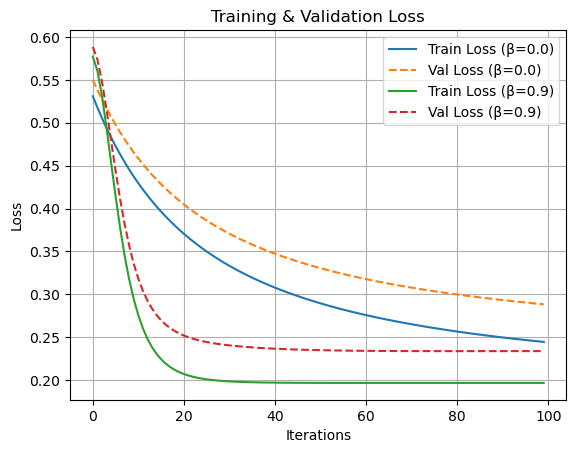

In [41]:
import matplotlib.pyplot as plt

plt.plot(losses_train_vanilla, label="Train Loss (β=0.0)", linestyle='-')
plt.plot(losses_val_vanilla, label="Val Loss (β=0.0)", linestyle='--')
plt.plot(losses_train_momentum, label="Train Loss (β=0.9)", linestyle='-')
plt.plot(losses_val_momentum, label="Val Loss (β=0.9)", linestyle='--')

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

We can see from the plot above that both the training a validation loss were minimized more quickly with momentum than without, which is expected given our above experiment with momentum. Now, let's use the test set to see how accurate our model is on this dataset. 

In [46]:
def evaluate(model, X, y):
    preds = model.predict(X)
    acc = (preds == y).float().mean().item()
    loss = model.loss(X, y).item()
    return acc, loss

test_acc, test_loss = evaluate(model_momentum, X_test, y_test)
print(f"Test Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.2f}")

Test Accuracy: 89.00%
Test Loss: 0.22


Our model is fairly accurate -- 89% on the test set. 

### Discussion